In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook MORDM will be used to 

In [1]:
# EMA Workbench imports
import ema_workbench
from ema_workbench import (
    Model, Constraint, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
    ema_logging, Constant, Scenario, HypervolumeMetric,
    GenerationalDistanceMetric, EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric, SpacingMetric)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords

# Problem formulation import
from problem_formulation import get_model_for_problem_formulation 
from ema_workbench.em_framework.optimization import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric
)

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
#Constants
output_dir = 'archives_test'
scenario_file = './data/Selected_Scenarios.csv'
epsilon_values = [[1e6, 1e6, 1e6, 1e6, 10]]
nfe = 100
outcomes_of_interest = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

In [4]:
def run_optimization(epsilon, scenarios, model, seeds=3):
    
    results = []
    convergences = []

    os.makedirs(output_dir, exist_ok=True)

    with MultiprocessingEvaluator(model) as evaluator:
        for scenario in scenarios:
            for seed in range(seeds):
                # Inside run_optimization()
                convergence_metrics = [
                    ArchiveLogger(
                        output_dir,
                        [lever.name for lever in model.levers],
                        [outcome.name for outcome in model.outcomes],
                        base_filename= "optimization.tar.gz"
                    ),
                    EpsilonProgress()
                ]
                # Optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario
                )

                # Filenames
                result_file = os.path.join(output_dir, f"result__scen{scenario.name}__seed{seed}.csv")
                convergence_file = os.path.join(output_dir, f"convergence__scen{scenario.name}__seed{seed}.csv")

                # Output
                result.to_csv(result_file, index=False)
                pd.DataFrame(convergence).to_csv(convergence_file, index=False)

                # Saving Output
                results.append(result)
                convergences.append(convergence)

    return results, convergences

In [5]:
def load_results_from_files(directory):
    """
    Loads all optimization result CSVs from a directory into a single DataFrame.
    """
    results = []
    for filename in os.listdir(directory):
        if filename.startswith("result__") and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            results.append(df)
    return pd.concat(results, ignore_index=True)


def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [6]:
def load_scenarios(filepath):
    df = pd.read_csv(filepath)
    scenarios = []
    for _, row in df.iterrows():
        name = row['scenario']
        parameters = row.drop(labels='scenario').to_dict()
        scenarios.append(Scenario(name, **parameters))
    return scenarios

In [7]:
def plot_parallel_coordinates(results, eps):
    outcomes = results[outcomes_of_interest]
    limits = parcoords.get_limits(outcomes)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(outcomes)
    plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
    plt.savefig(f'parallel_coordinates_eps_{eps}.png')
    plt.show()

[MainProcess/INFO] pool started with 24 workers
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.50it/s]
[MainProcess/INFO] optimization completed, found 23 solutions
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 38.75it/s]
[MainProcess/INFO] optimization completed, found 15 solutions
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 37.44it/s]
[MainProcess/INFO] optimization completed, found 12 solutions
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 38.06it/s]
[MainProcess/INFO] optimization completed, found 28 solutions
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.33it/s]
[MainProcess/INFO] optimization completed, found 19 solutions
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.87it/s]
[MainProcess/INFO] optimization completed, found 17 solutions
100%|████████████████████████████████████████| 100/100 [00:02<00:00, 43.82it/s]
[MainProcess/INFO] o

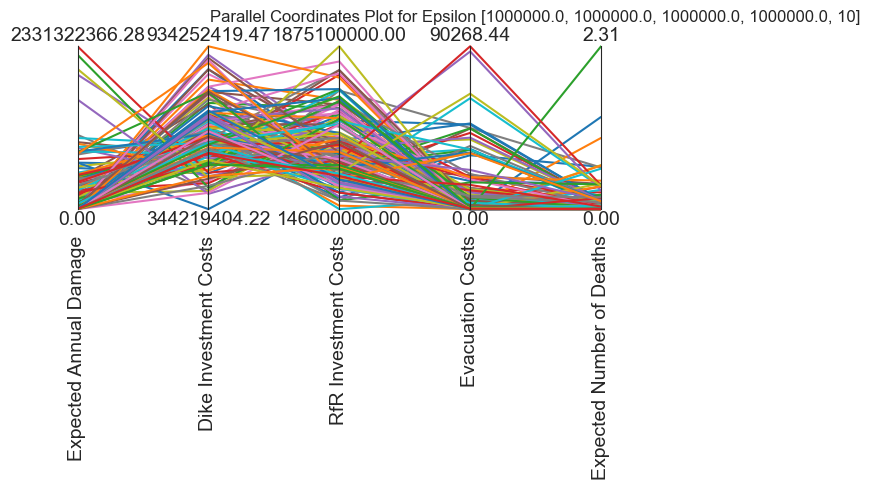

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

ensure_directory_exists(output_dir)

model, steps = get_model_for_problem_formulation(2)
scenarios = load_scenarios(scenario_file)

for eps in epsilon_values:
    results, convergences = run_optimization(eps, scenarios, model)
    optimization_results = load_results_from_files(output_dir)
    plot_parallel_coordinates(optimization_results, eps)

In [11]:
print(len(optimization_results))

134


In [ ]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem


def calculate_metrics(archives, reference_set):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel(r'$\epsilon$ progress')

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

In [ ]:
archives = ArchiveLogger.load_archives(f"./archives/tutorial.tar.gz")
reference_set = archives[max(archives.keys())]  # this is the final archive

In [ ]:
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

In [33]:
def get_minimizing_policies(objectives: np.ndarray) -> np.ndarray:
    """
    Return a boolean mask indicating Pareto-optimal (non-dominated) policies.
    Assumes all objectives are to be minimized.
    """
    is_efficient = np.ones(objectives.shape[0], dtype=bool)
    for i, c in enumerate(objectives):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(objectives[is_efficient] < c, axis=1) | np.all(objectives[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [34]:
def filter_pareto_optimal_policies(df, objectives):
    """
    Filters a DataFrame to retain only the Pareto-optimal rows (minimization).
    """
    objective_values = df[objectives].values
    pareto_mask = get_minimizing_policies(objective_values)
    return df[pareto_mask]


In [ ]:
pareto_results = filter_pareto_optimal_policies(
    optimization_results, outcomes_of_interest)
pareto_results.to_csv("Pareto_Optimal_Results.csv", index=False)
print("Saved Pareto-optimal policies to pareto_optimal_results.csv")

Saved Pareto-optimal policies to pareto_optimal_results.csv
